# Statistics on Decision Tree

We will arange data and train Desicion trees on the data.
The we will try to train again only using quarters from the same cluster (using the quarter classifier).

Our randomly chosen 5 stocks are: 
'SHW', 'MNK', 'BIO', 'KYTH', 'KRO'

# Basic Tree

In [1]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product

from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging
import pandas

%matplotlib inline

ld = LearningData()

In [2]:
stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.INFO)
stocks = [TrainingData(sn).add_history(10).set_threshold(0.8).get() for sn in stock_names]

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018134653877025918
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.026397640541565882
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.018548151336335694
INFO:root:TrainingData: name=KYTH, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=KYTH, days_forward=1: threshold found is 0.036464497748678756
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.0321798749747933


In [3]:
import os
print("Samples per stock:")
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print("percent of positive classification per stock")
print(os.linesep.join(['{} {}'.format(sn, float(classes.sum())/len(classes)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

Samples per stock:
SHW 7855
MNK 819
BIO 2343
KYTH 718
KRO 3220
percent of positive classification per stock
SHW 0.20038192234245703
MNK 0.1978021978021978
BIO 0.15151515151515152
KYTH 0.201949860724234
KRO 0.20031055900621117
             change        close   ex-divident         high           low  \
count  7.855000e+03  7855.000000  7.855000e+03  7855.000000  7.855000e+03   
mean   2.170977e-17     0.000000  1.447318e-17     0.000000 -1.447318e-16   
std    1.000064e+00     1.000064  1.000064e+00     1.000064  1.000064e+00   
min   -9.826291e-01    -0.711964 -8.285474e-02    -0.708525 -7.122042e-01   
25%   -6.546142e-01    -0.545740 -8.285474e-02    -0.546135 -5.453623e-01   
50%   -2.623907e-01    -0.438244 -8.285474e-02    -0.440260 -4.366827e-01   
75%    3.430775e-01    -0.053682 -8.285474e-02    -0.052620 -5.562959e-02   
max    1.404981e+01     3.669051  2.486545e+01     3.637710  3.656416e+00   

               open   split_ratio        volume  change1_days_before  \
count  7

In [21]:
def run_model(model, inp=stocks):
    scores = {sn: [] for sn in stock_names}
    validation_rounds = 3
    for i in range(validation_rounds):
        for sn, (data, classes) in zip(stock_names, inp):
            scores[sn].append(sum(cross_val_score(model, data, classes))/3) 
    for sn in scores.keys():
        scores[sn] = sum(scores[sn])/validation_rounds
    return scores

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum(accs.values()) > best_model[0]:
            best_model = (sum(accs.values()), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median(accs.values()) > best_model[0]:
            best_model = (median(accs.values()), model)
    return best_model

In [5]:
from sklearn.tree import DecisionTreeClassifier
from pandas import DataFrame
cuts=[]

for i in range(1, 51):
    tmodel = DecisionTreeClassifier(min_samples_leaf=0.05, max_depth=30)
    tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), i))), classes) for data, classes in stocks]
    temp_accs = [run_model(tmodel, tree_stocks)]
    data = []
    taccs = temp_accs[0]
    for tsn, tacc in taccs.items():
        data.append((tmodel.criterion, tmodel.max_depth, tmodel.min_samples_leaf, tsn, tacc))
    temp_results = DataFrame(data, columns=('criterion', 'max_depth', 'min_samples', 'stock', 'accuracy'))
    cuts.append((temp_results['accuracy'].median(), i))
        

KeyboardInterrupt: 

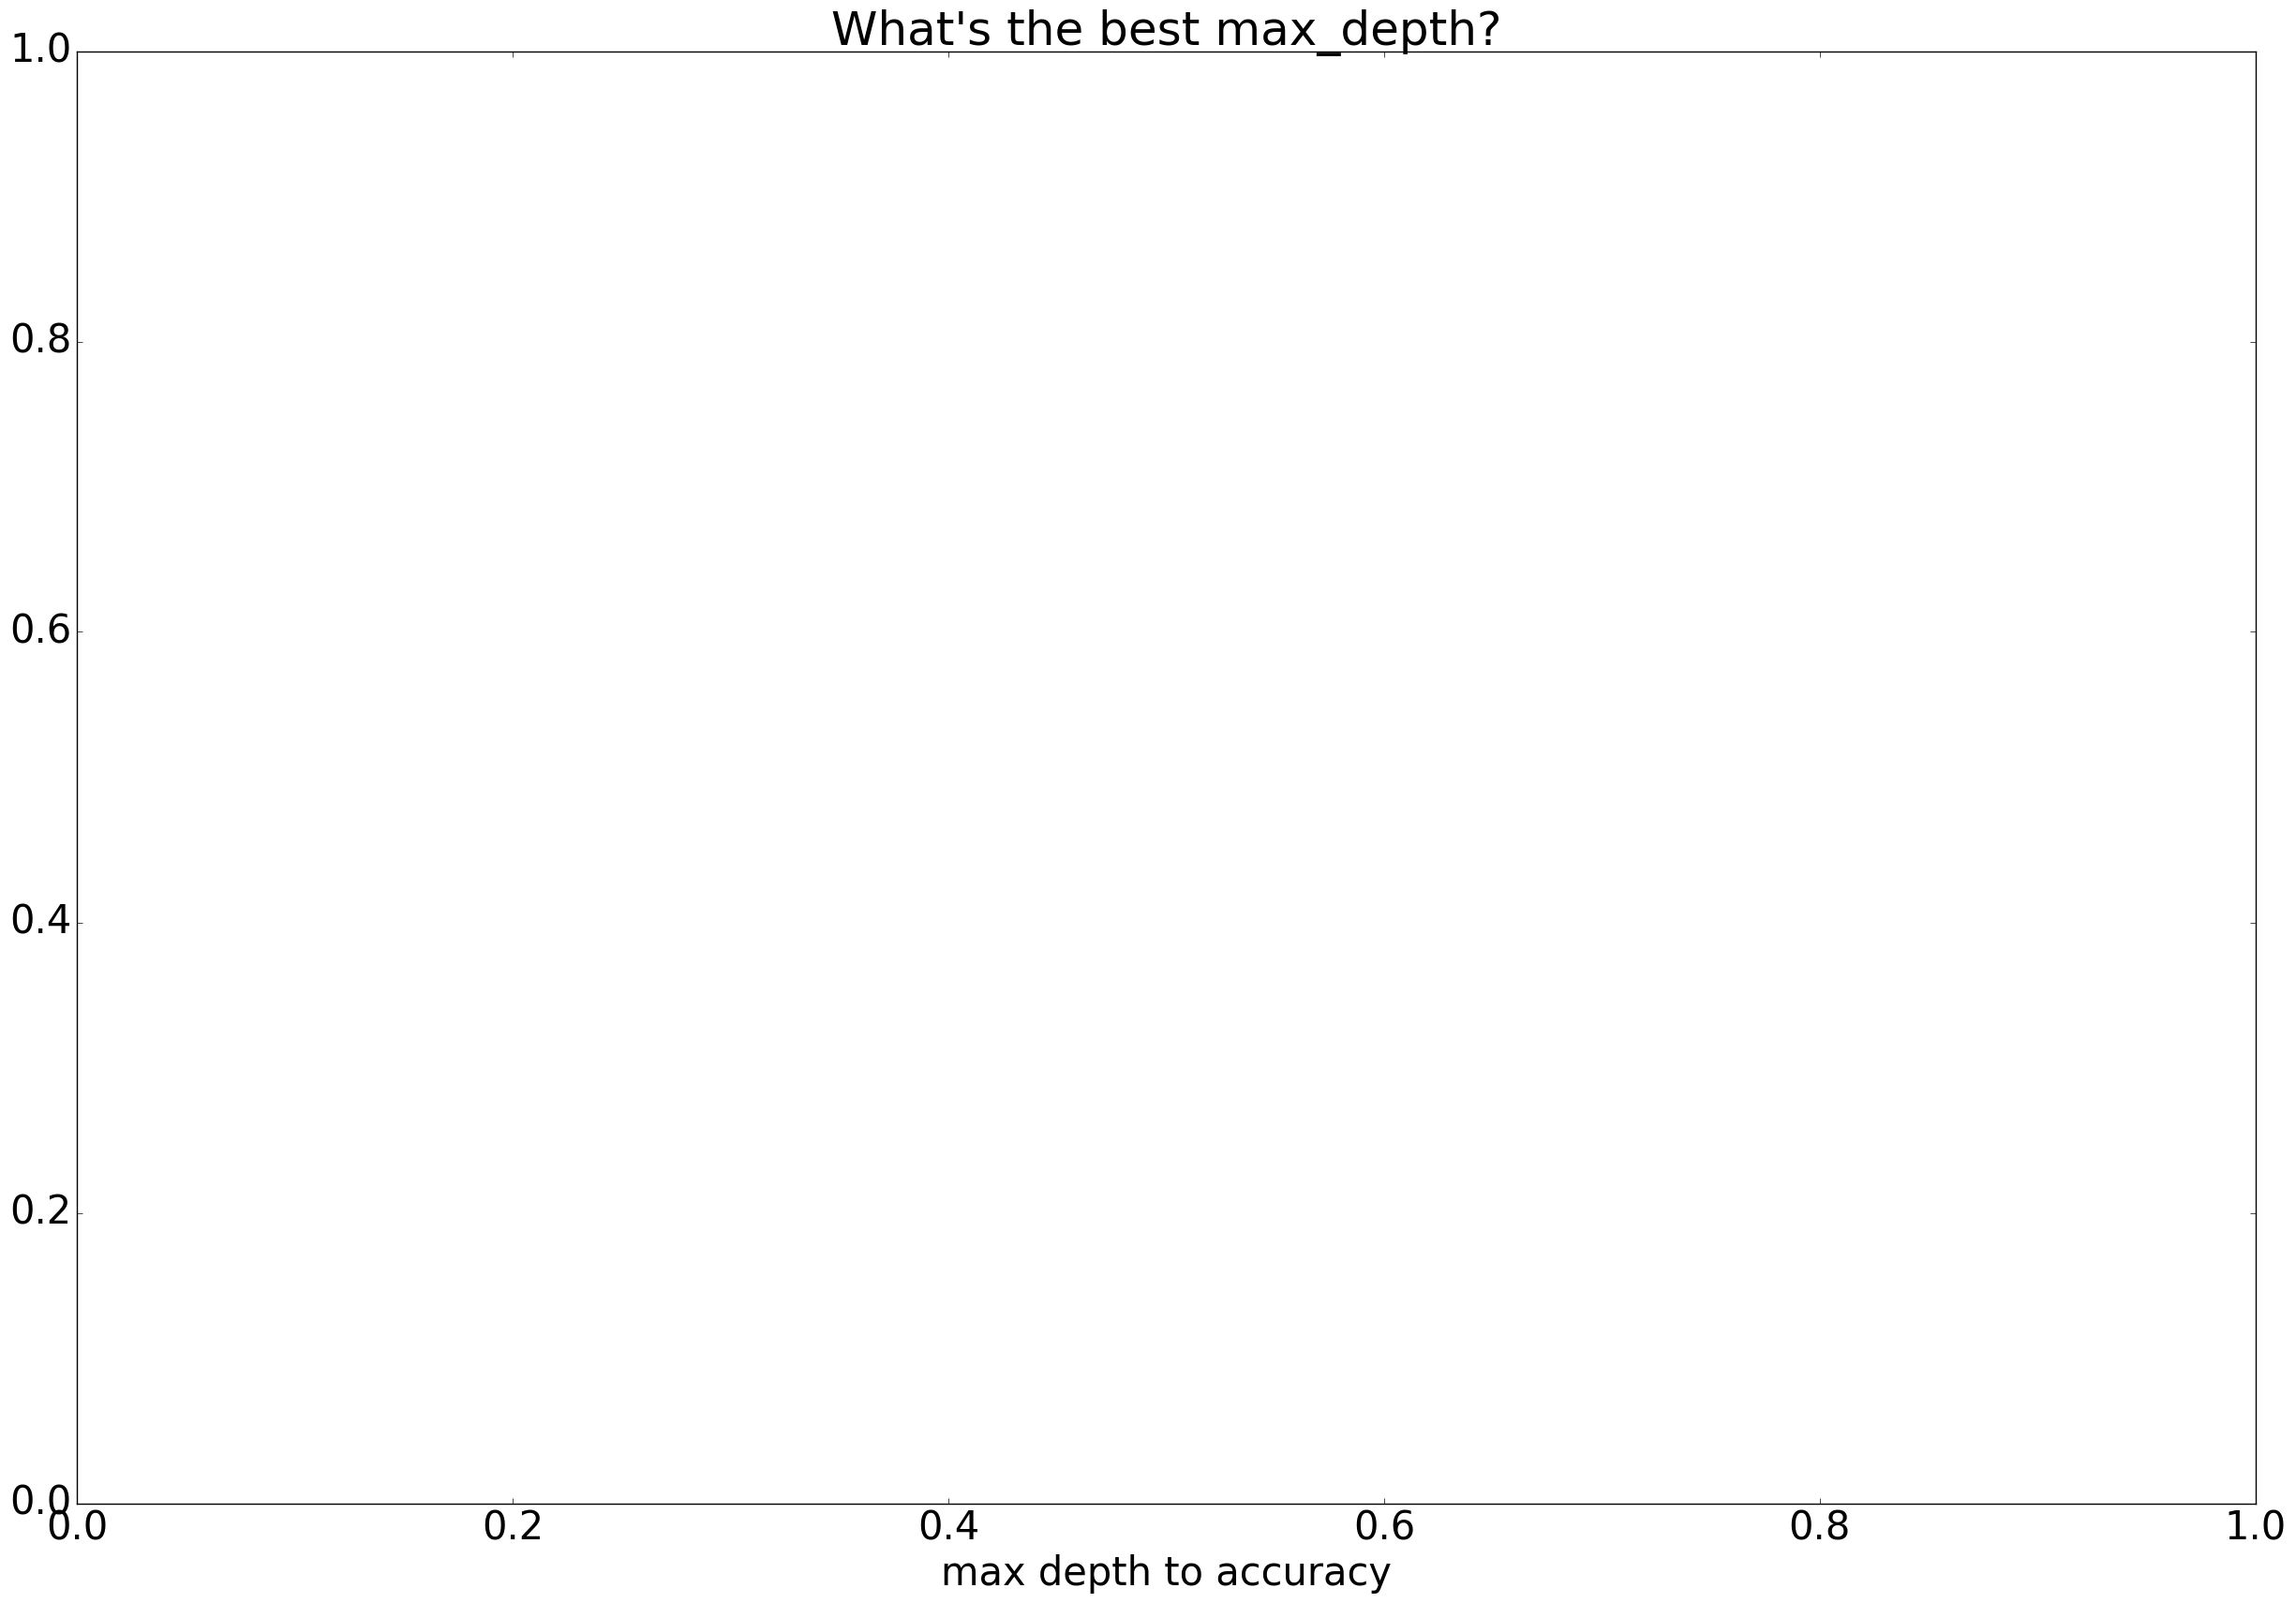

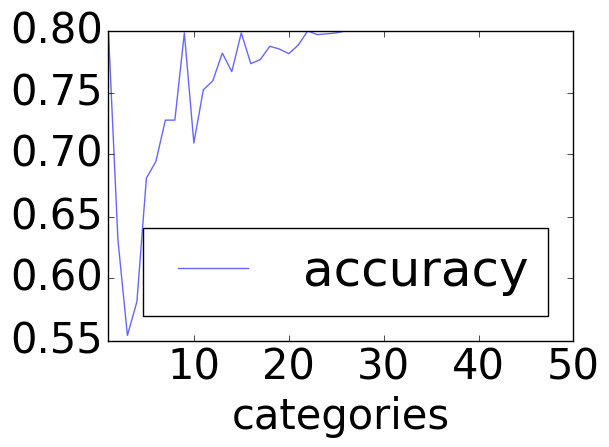

In [15]:
from pandas import DataFrame
res = DataFrame(cuts, columns=['accuracy', 'categories'])
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
res = res.set_index('categories')
res.plot(kind='line', label='accuracy', alpha=alpha)
ax1.set_xlabel('max depth to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_depth?" )

In [7]:
best_cut=15

In [8]:
from sklearn.tree import DecisionTreeClassifier

# create iterables for all options and use itertools product
criterion=['gini', 'entropy']
max_depth=[5, 10, 50]
# using percentages
min_samples_leaf=[0.005, 0.01, 0.02, 0.05, 0.1]

tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), best_cut))), classes) for data, classes in stocks]

tmodels = [DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_leaf=msl) 
          for c, md, msl in product(criterion, max_depth, min_samples_leaf)]

In [9]:
def run_model_t(model):
    return run_model(model, tree_stocks)
taccuracies = list(map(run_model_t, tmodels))

In [11]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for tmodel, taccs in zip(tmodels, taccuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.criterion, tmodel.max_depth, tmodel.min_samples_leaf, tsn, tacc))
tresults = DataFrame(data, columns=('criterion', 'max_depth', 'min_samples', 'stock', 'accuracy'))

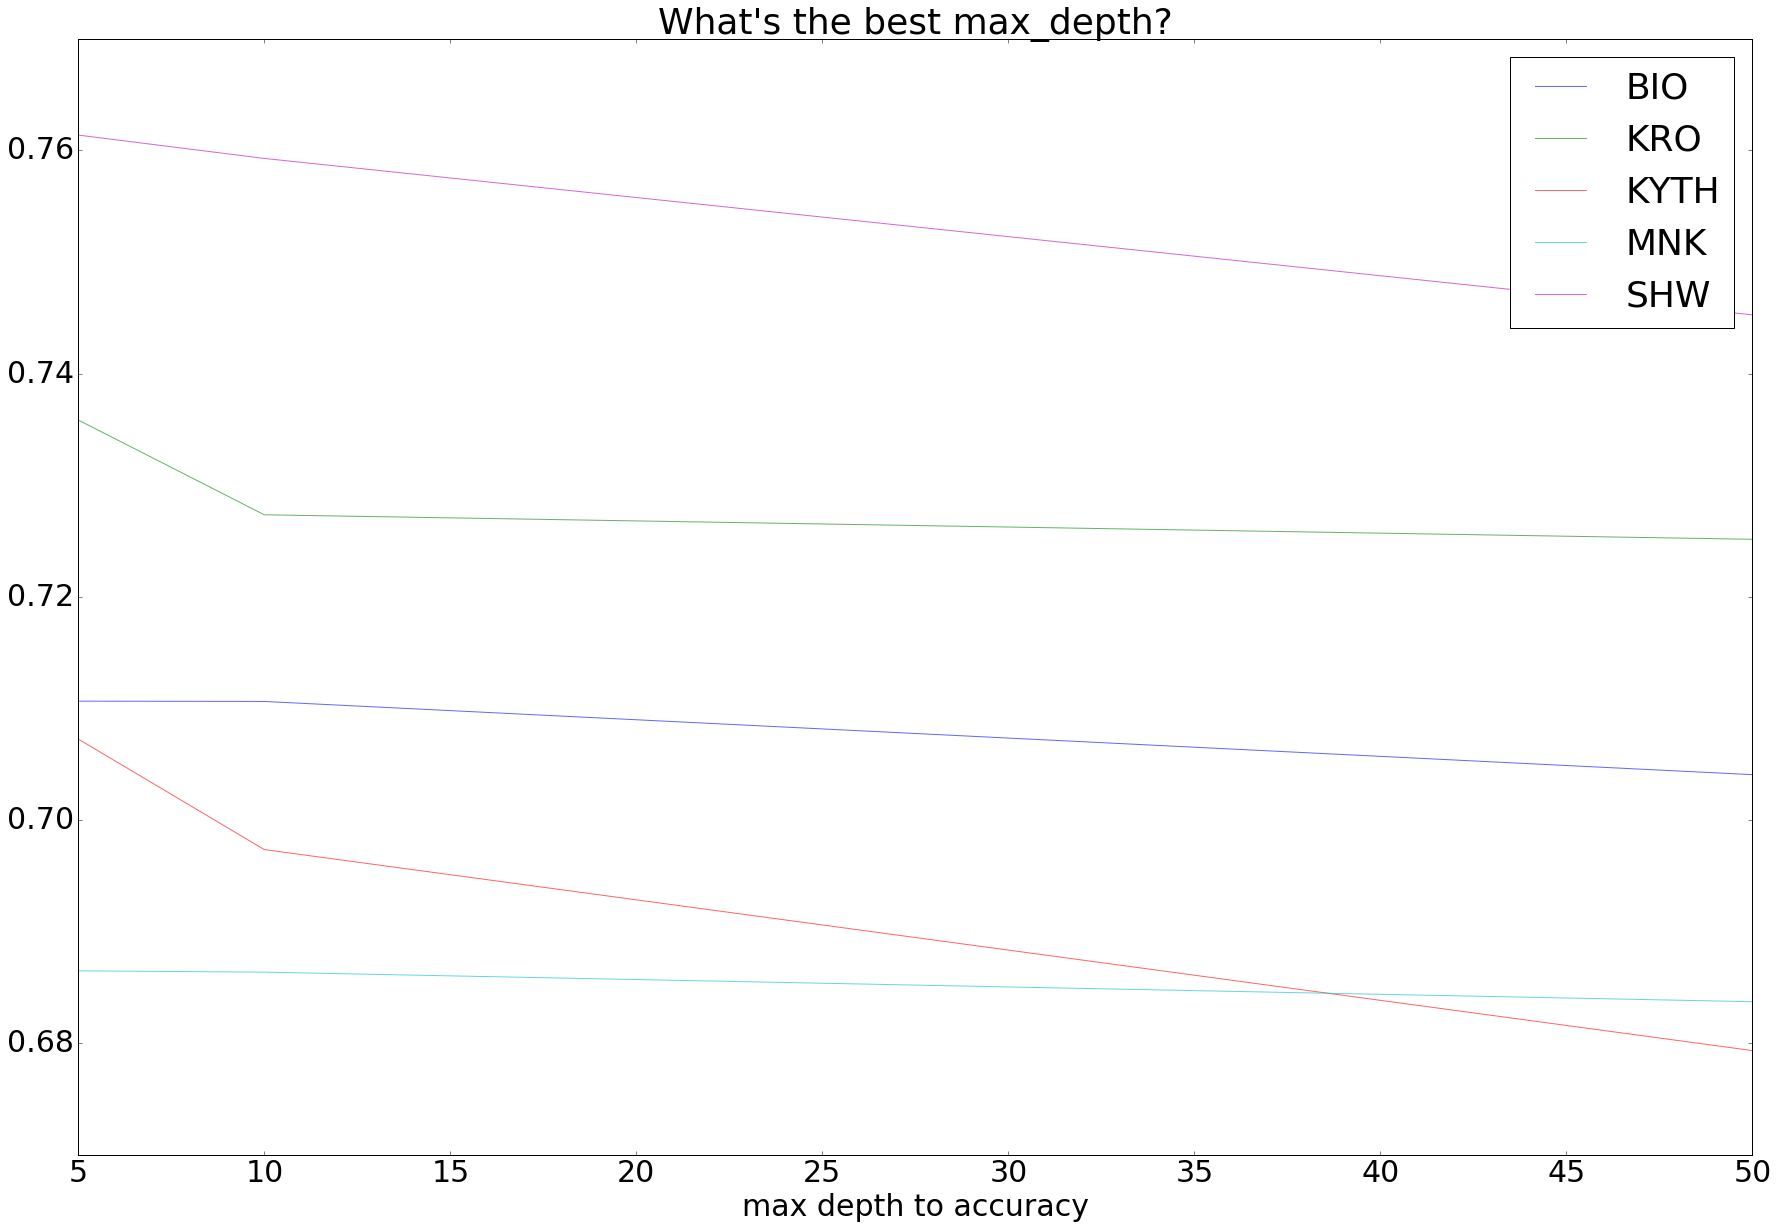

In [12]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in tresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('max_depth').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max depth to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_depth?" )

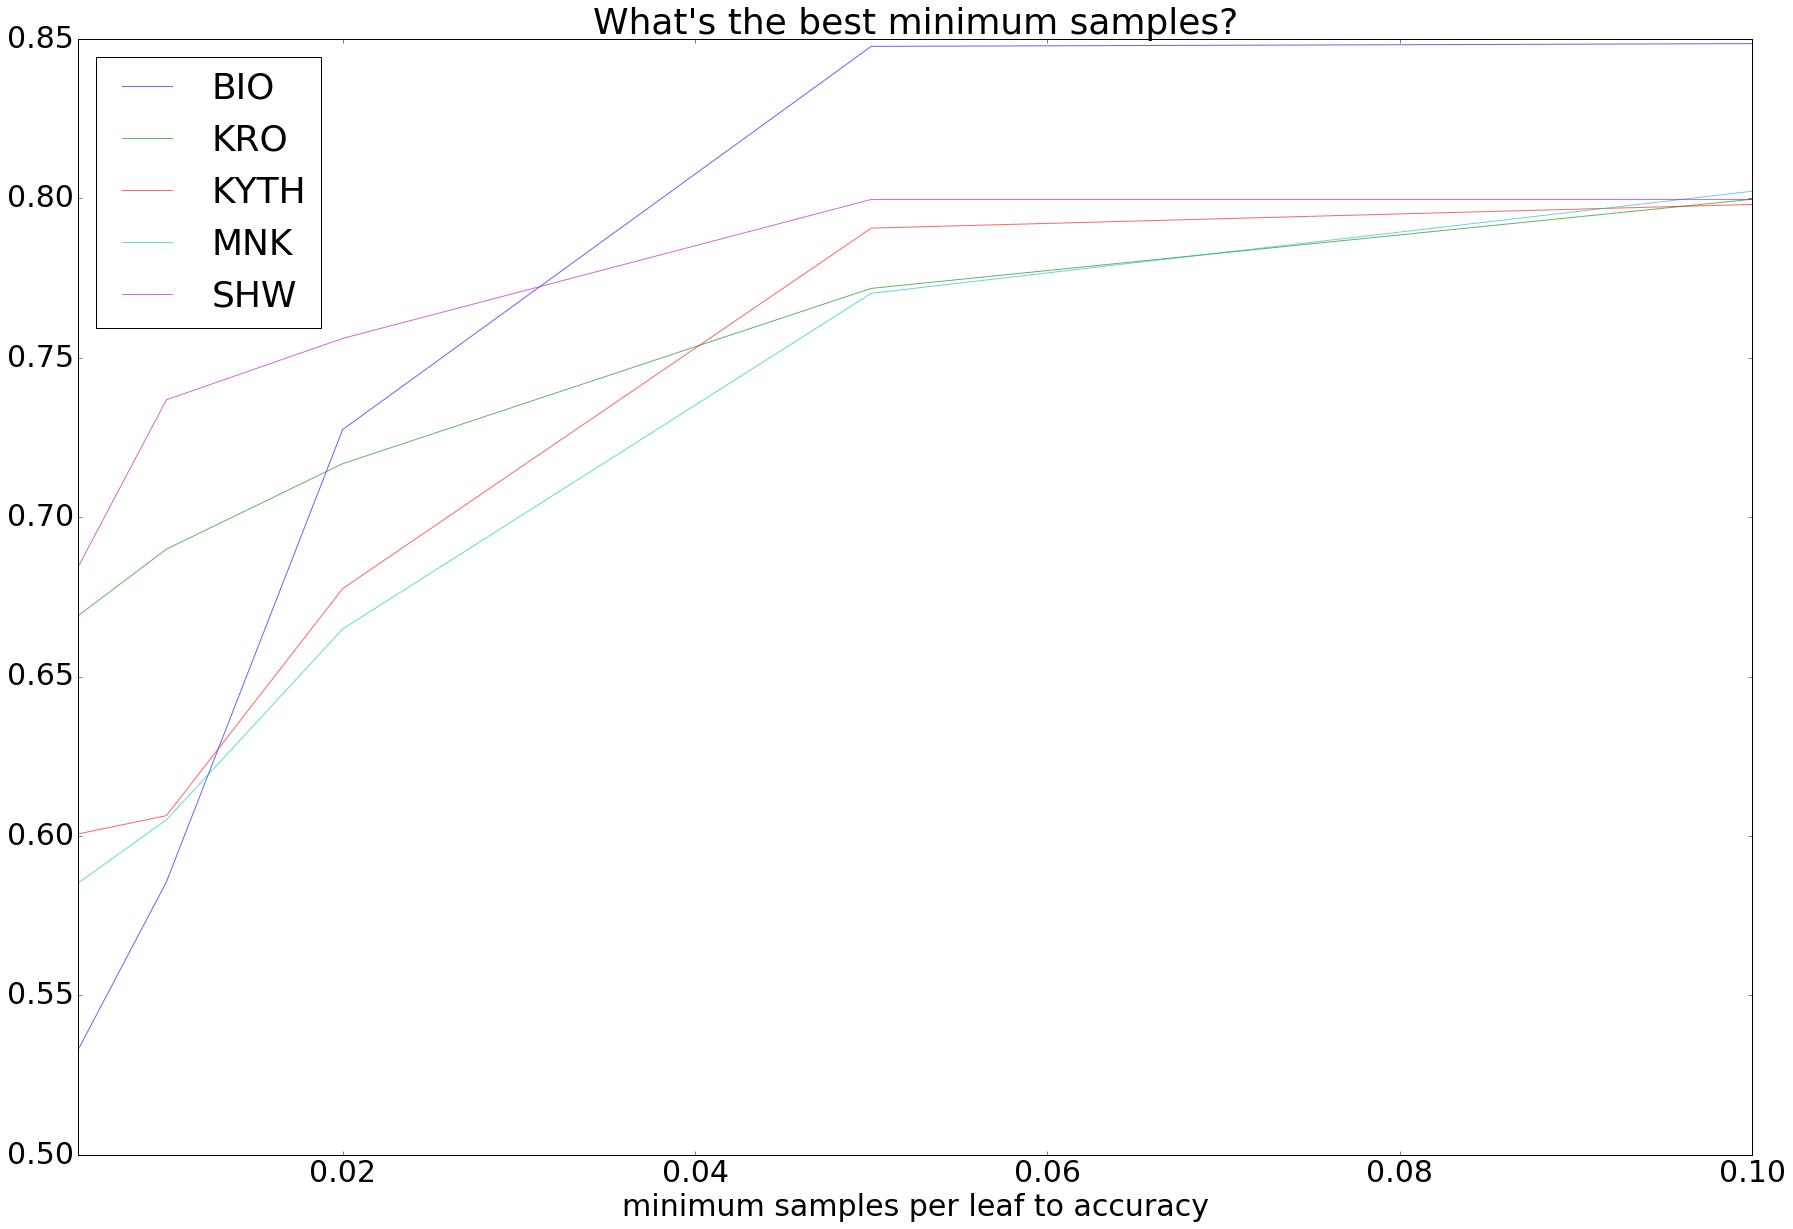

In [13]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in tresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('min_samples').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('minimum samples per leaf to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best minimum samples?" )

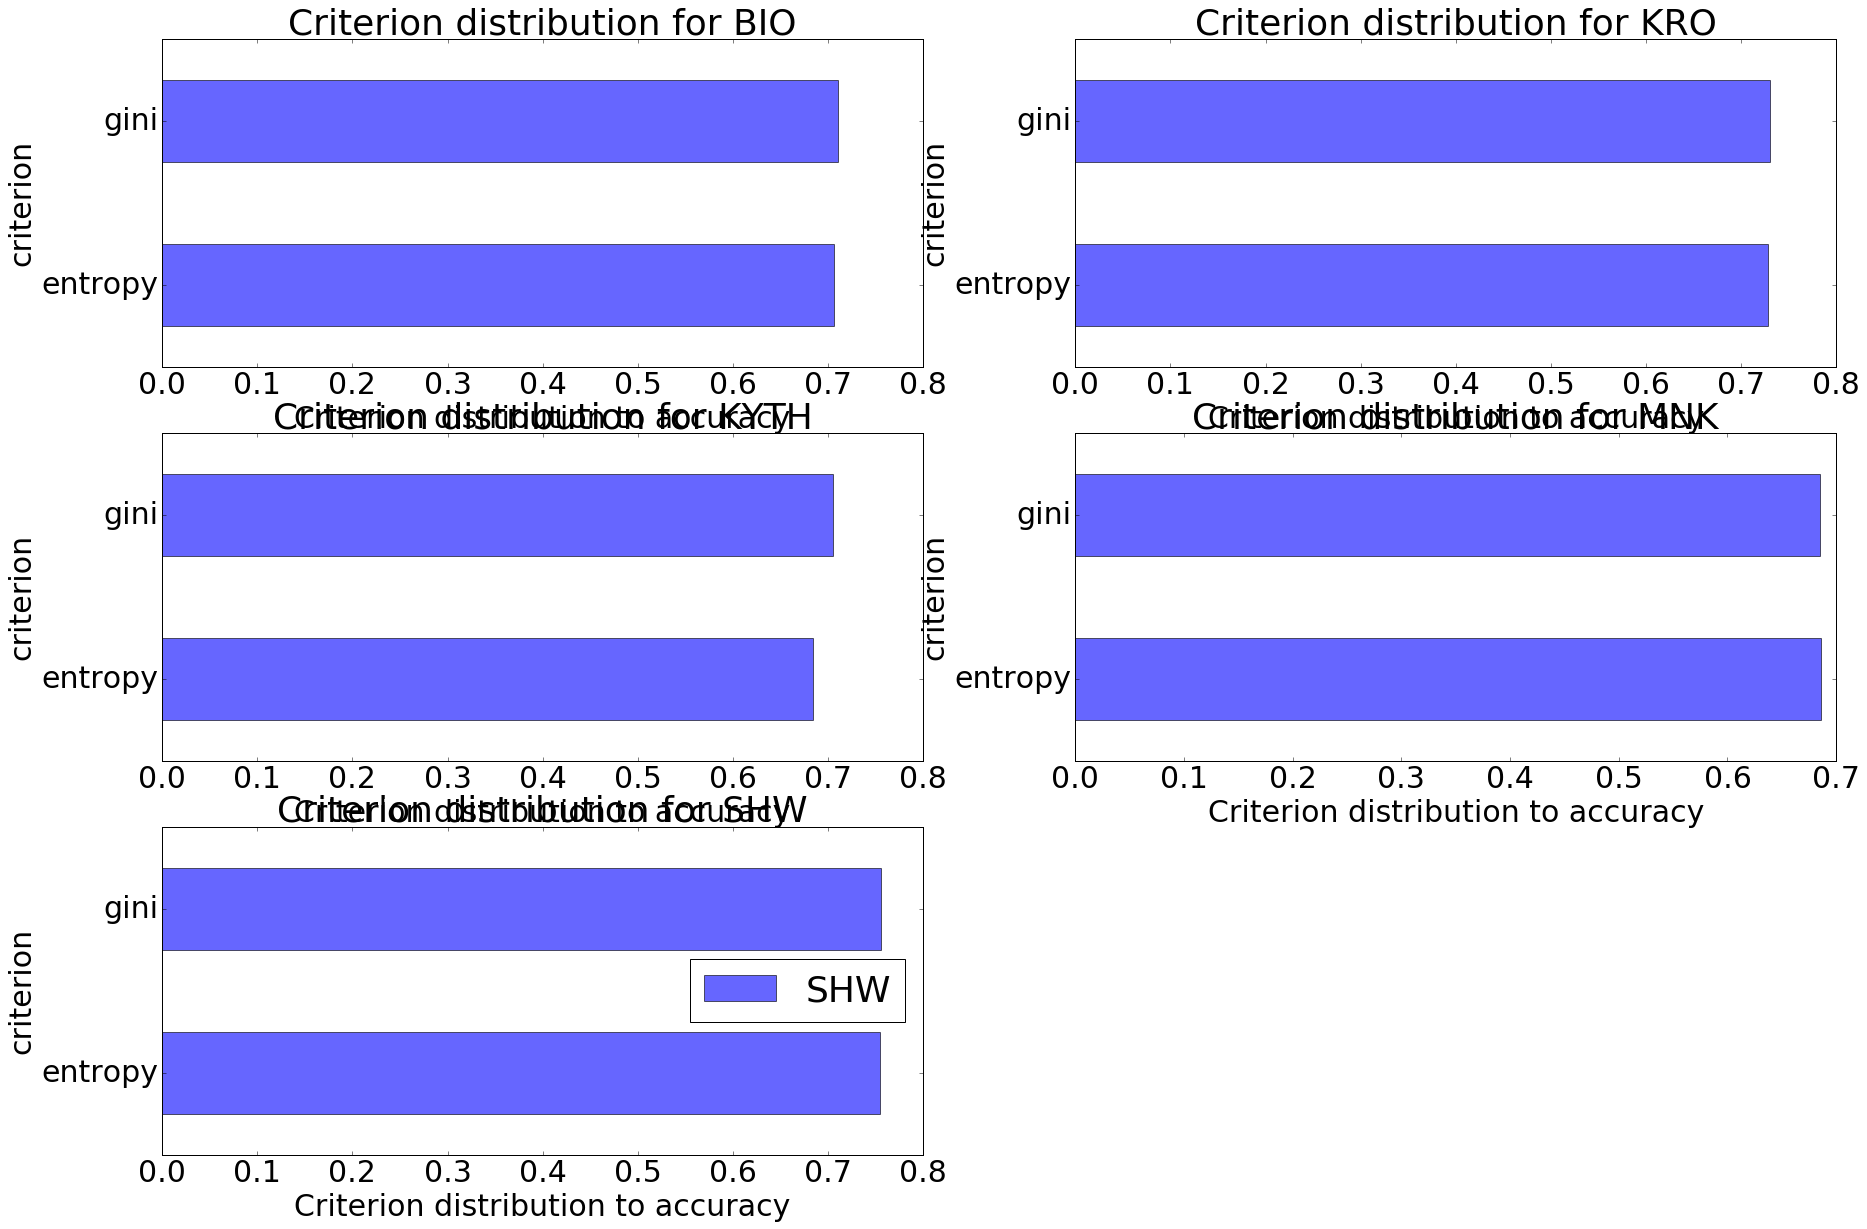

In [14]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(tresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('criterion').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('Criterion distribution to accuracy')
    ax1.set_title("Criterion distribution for {}".format(name))
plt.legend(loc='best')


The best average accuracy model is:

In [15]:
print(get_best_model(tmodels, taccuracies))
print(get_best_median_model(tmodels, taccuracies))

(4.0480437812697501, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
(0.79968940236711372, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


Which is like just saying always false but we can work with it because we use adaboost later on. An important note is that we don't want to increase the amount of samples per leaf or decrease max depth as the classifier will be meaningless. Even we prefer to look at less samples per leaf so we will have more then 20 leaves:

In [16]:
t2combined = [(model, accs) for model, accs in zip(tmodels, taccuracies) if model.min_samples_leaf < 0.05]
t2models = [top[0] for top in t2combined]
t2accuracies = [top[1] for top in t2combined]

print(get_best_model(t2models, t2accuracies))
print(get_best_median_model(t2models, t2accuracies))

(3.5976493418241215, DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
(0.716744388387617, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


# Variance Reduction
We will try 3 approches. 

    1. using standard sklearn feature selection. 
    2. using QuarterClusterer try using data with less variance.
    3. using relation strength classifier.

## Standard feature selection

We have plenty of samples so it seems wiser to use mutual_info score func, and trying to remove features by those who have small variance.

In [28]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

def run_model(model, inp=stocks):
    scores = {sn: [] for sn in stock_names}
    for sn, (data, classes) in zip(stock_names, inp):
        scores[sn] = sum(cross_val_score(model, data, classes))/3)
    return scores


results = []
for i in range(1, 51, 1):
    filtered_tree_stocks = [(SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(data, classes), classes) for data, classes in tree_stocks]
    results.append((i, sum(run_model(DecisionTreeClassifier(), filtered_tree_stocks).values())))
    
results.sort(key=lambda t: t[1])
for t in results[:10]:
    print('{} {}'.format(t[0],t[1]))


KeyboardInterrupt: 

In [ ]:
from sklearn.feature_selection import VarianceThreshold

results2 = []
for i in range(1, 11):
    filtered_tree_stocks = [(VarianceThreshold(threshold=float(i)/10).fit_transform(data, classes), classes) for data, classes in tree_stocks]
    results.append((i, sum(run_model(DecisionTreeClassifier(), filtered_tree_stocks).values())))
    
results2.sort(key=lambda t: t[1])
for t in results2:
    print('{} {}'.format(t[0],t[1]))

# Using the Quarter Classifier

The idea is that some quarters behave the same and so we can really decrease our data's variance if we cluster them together and then try to predict with the narowred down data.

In [3]:
import Classifiers
from Classifiers.classifiers import Quarter

q_clusterer = Classifiers.create_quarter_clusterer(ld)

NameError: name 'stock_name' is not defined

In [11]:
import functools

quarters = [list(map(lambda q: q.ready_quarter_data(360), Quarter.split_by_quarters(sn, data))) for sn, (data, classes) in zip(stock_names, stocks)]
drop_cols = list(ld.get_stock_data(stock_names[0]).columns)
drop_cols.remove('open')
drop_cols.remove('volume')
quarters = list(functools.reduce(lambda x, y: x+y, quarters))

In [20]:
def arrange_data_frame(data: pandas.DataFrame, length: int):
    res = None
    data = data.iloc[0:length]

    for i, c in enumerate(data.columns):
        cur = data[c]
        cur.index = list(range(i*length, (i+1)*length))
        if res is None:
            res = cur
            continue
        res = res.append(cur)
    return res

In [12]:
import collections

c_to_qs = collections.defaultdict(lambda: [])

In [24]:
for q, c in zip(quarters, q_clusterer.predict(list(map(lambda q: arrange_data_frame(q.data, 353), quarters)))):
    c_to_qs[c].append(q)

In [49]:
for c, qs in c_to_qs.items():
    all_dc = [TrainingData(q.name.split('-')[0], startdate=q.start, enddate=q.end, threshold=0.8).add_history(10) for q in qs]
    data = []
    classes = []
    for sn in stock_names:
        temp_d = []
        temp_c = []
        for td in filter(lambda td: td.name == sn, all_dc):
            d, c = td.get()
            temp_d.append(d)
            temp_c.append(c)
        try:
            data.append(functools.reduce(lambda a, b: pandas.concat([a, b]), temp_d))
            classes.append(functools.reduce(lambda a, b: pandas.concat([a, b]), temp_c))
        except:
            continue
    data = [TrainingData.cleanup_data(d) for d in data]

    model1 = get_best_model(t2models, t2accuracies)[1]
    accs = run_model(model1, list(zip(data, classes)))
    print("{}: {}".format(c, accs))



INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.0267292156517323
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.02481809237743613
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.024001884762659062
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.0243109083813055
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.014813238765127634
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.013037832492974922
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.021883881400335255
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01452067753275805
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.028796368591278522
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.02104525710643102
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.017839239158054056
INFO:root:Trainin

date
2016-07-01    False
2016-07-05     True
2016-07-06    False
2016-07-07    False
2016-07-08     True
2016-07-11    False
2016-07-12     True
2016-07-13    False
2016-07-14    False
2016-07-15    False
2016-07-18    False
2016-07-19     True
2016-07-20    False
2016-07-21    False
2016-07-22    False
2016-07-25    False
2016-07-26     True
2016-07-27    False
2016-07-28    False
2016-07-29    False
2016-08-01    False
2016-08-02    False
2016-08-03    False
2016-08-04    False
2016-08-05    False
2016-08-08     True
2016-08-09    False
2016-08-10    False
2016-08-11    False
2016-08-12    False
2016-08-15     True
2016-08-16     True
2016-08-17    False
2016-08-18    False
2016-08-19     True
2016-08-22    False
2016-08-23    False
2016-08-24    False
2016-08-25     True
2016-08-26    False
2016-08-29     True
2016-08-30    False
2016-08-31    False
2016-09-01    False
2016-09-02    False
2016-09-06    False
2016-09-07    False
2016-09-08    False
2016-09-09     True
2016-09-12     

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.014561780175750775
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.010470521895491898
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.021123329480709264
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.019318005366236752
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.012185466879709703
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.009341612687796479
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.03136893998147969



date
2011-04-01    False
2011-04-04    False
2011-04-05    False
2011-04-06    False
2011-04-07    False
2011-04-08    False
2011-04-11    False
2011-04-12    False
2011-04-13    False
2011-04-14    False
2011-04-15    False
2011-04-18    False
2011-04-19    False
2011-04-20    False
2011-04-21    False
2011-04-25    False
2011-04-26    False
2011-04-27    False
2011-04-28    False
2011-04-29    False
2011-05-02    False
2011-05-03    False
2011-05-04     True
2011-05-05     True
2011-05-06    False
2011-05-09    False
2011-05-10    False
2011-05-11    False
2011-05-12     True
2011-05-13    False
2011-05-16    False
2011-05-17    False
2011-05-18     True
2011-05-19    False
2011-05-20    False
2011-05-23    False
2011-05-24    False
2011-05-25    False
2011-05-26    False
2011-05-27     True
2011-05-31     True
2011-06-01    False
2011-06-02    False
2011-06-03    False
2011-06-06    False
2011-06-07    False
2011-06-08    False
2011-06-09    False
2011-06-10    False
2011-06-13    

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.0238815467021425
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.010627930741388071
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.013781512605042005
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.011651678914481971
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01511784175165661
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.013291602851652297
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.014380000186028159
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.012995382801272702
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.008780129278374625



date
2016-07-01    False
2016-07-05     True
2016-07-06     True
2016-07-07    False
2016-07-08    False
2016-07-11    False
2016-07-12    False
2016-07-13    False
2016-07-14    False
2016-07-15    False
2016-07-18    False
2016-07-19    False
2016-07-20    False
2016-07-21    False
2016-07-22    False
2016-07-25    False
2016-07-26     True
2016-07-27    False
2016-07-28    False
2016-07-29    False
2016-08-01     True
2016-08-02     True
2016-08-03    False
2016-08-04     True
2016-08-05    False
2016-08-08     True
2016-08-09    False
2016-08-10    False
2016-08-11    False
2016-08-12    False
2016-08-15    False
2016-08-16    False
2016-08-17    False
2016-08-18    False
2016-08-19    False
2016-08-22    False
2016-08-23    False
2016-08-24     True
2016-08-25    False
2016-08-26    False
2016-08-29    False
2016-08-30    False
2016-08-31     True
2016-09-01    False
2016-09-02    False
2016-09-06    False
2016-09-07     True
2016-09-08    False
2016-09-09    False
2016-09-12    

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.031398374809548074
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.025319638060653377
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.012538500210397291
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.03721108585866917
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.04745586905742849
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.029073390639039673
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.02440737646358878
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018404373716211363
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.016439896117037167
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.013478513197092593
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01317730010841306
INFO:root:Trai


date
2014-01-02    False
2014-01-03    False
2014-01-06     True
2014-01-07    False
2014-01-08    False
2014-01-09    False
2014-01-10    False
2014-01-13    False
2014-01-14    False
2014-01-15    False
2014-01-16     True
2014-01-17    False
2014-01-21    False
2014-01-22    False
2014-01-23    False
2014-01-24     True
2014-01-27    False
2014-01-28    False
2014-01-29    False
2014-01-30    False
2014-01-31     True
2014-02-03    False
2014-02-04    False
2014-02-05    False
2014-02-06    False
2014-02-07    False
2014-02-10    False
2014-02-11    False
2014-02-12     True
2014-02-13    False
2014-02-14     True
2014-02-18    False
2014-02-19     True
2014-02-20    False
2014-02-21    False
2014-02-24     True
2014-02-25    False
2014-02-26    False
2014-02-27     True
2014-02-28    False
2014-03-03    False
2014-03-04     True
2014-03-05    False
2014-03-06    False
2014-03-07     True
2014-03-10    False
2014-03-11    False
2014-03-12    False
2014-03-13    False
2014-03-14    

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01962509883143301
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.025807069710668373
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01615828740674084
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.016288204899713256
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.015721655911738644
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.016944355117855275
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.020109443384095593
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.028745401137547866
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.019166055856174466



date
2013-07-01     True
2013-07-02     True
2013-07-03     True
2013-07-05    False
2013-07-08    False
2013-07-09    False
2013-07-10    False
2013-07-11    False
2013-07-12    False
2013-07-15    False
2013-07-16    False
2013-07-17    False
2013-07-18    False
2013-07-19    False
2013-07-22    False
2013-07-23    False
2013-07-24     True
2013-07-25     True
2013-07-26    False
2013-07-29    False
2013-07-30    False
2013-07-31    False
2013-08-01    False
2013-08-02     True
2013-08-05     True
2013-08-06     True
2013-08-07    False
2013-08-08    False
2013-08-09    False
2013-08-12    False
2013-08-13    False
2013-08-14    False
2013-08-15    False
2013-08-16     True
2013-08-19    False
2013-08-20    False
2013-08-21    False
2013-08-22    False
2013-08-23    False
2013-08-26    False
2013-08-27    False
2013-08-28    False
2013-08-29    False
2013-08-30    False
2013-09-03    False
2013-09-04    False
2013-09-05    False
2013-09-06    False
2013-09-09     True
2013-09-10    

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.015064332879268016
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.014738988535103095
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01983459347746907
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.019141486357994775
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.015748297045368686
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01974073262011865
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.02292420223217502
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.047043384286527545
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.029637052310462292
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.01871313399985338
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.026092313422972642
INFO:root:Trai


date
2015-07-01    False
2015-07-02    False
2015-07-06    False
2015-07-07    False
2015-07-08    False
2015-07-09    False
2015-07-10    False
2015-07-14    False
2015-07-15    False
2015-07-16    False
2015-07-17     True
2015-07-20     True
2015-07-21    False
2015-07-22    False
2015-07-23    False
2015-07-24     True
2015-07-27    False
2015-07-28    False
2015-07-29    False
2015-07-30    False
2015-07-31    False
2015-08-03    False
2015-08-04    False
2015-08-05    False
2015-08-06    False
2015-08-07    False
2015-08-10     True
2015-08-11     True
2015-08-12    False
2015-08-13    False
2015-08-14    False
2015-08-17    False
2015-08-18    False
2015-08-19    False
2015-08-20    False
2015-08-21    False
2015-08-24    False
2015-08-25     True
2015-08-26    False
2015-08-27    False
2015-08-28    False
2015-08-31    False
2015-09-01    False
2015-09-02     True
2015-09-03    False
2015-09-04     True
2015-09-08    False
2015-09-09     True
2015-09-10    False
2015-09-11    

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01322632875747976
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.020845689469409456
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.022164596546864025
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.024149301500370292
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.024022244289970237
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.0194336318808494
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018508144869164425
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018914246209153406
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.04107411385606874
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.024135049545408162
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018287446324829506
INFO:root:Trai


date
2012-01-03    False
2012-01-04     True
2012-01-05    False
2012-01-06     True
2012-01-09     True
2012-01-10    False
2012-01-11    False
2012-01-12    False
2012-01-13    False
2012-01-17    False
2012-01-18    False
2012-01-19    False
2012-01-20    False
2012-01-23     True
2012-01-24    False
2012-01-25     True
2012-01-26    False
2012-01-27    False
2012-01-30    False
2012-01-31    False
2012-02-01     True
2012-02-02    False
2012-02-03    False
2012-02-06    False
2012-02-07    False
2012-02-08    False
2012-02-09    False
2012-02-10    False
2012-02-13     True
2012-02-14     True
2012-02-15    False
2012-02-16     True
2012-02-17    False
2012-02-21    False
2012-02-22    False
2012-02-23    False
2012-02-24    False
2012-02-27     True
2012-02-28    False
2012-02-29    False
2012-03-01    False
2012-03-02    False
2012-03-05    False
2012-03-06     True
2012-03-07    False
2012-03-08    False
2012-03-09    False
2012-03-12     True
2012-03-13    False
2012-03-14    